In [1]:
import EoN
import numpy as np
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import random


from tqdm.autonotebook import tqdm
import time

plt.style.use('seaborn-white')
sns.set_style("ticks")
sns.set_context("talk")
%matplotlib inline

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
/Users/agarbuno/anaconda2/envs/risknet/lib/python3.6/site-packages/ipykernel_launcher.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  # This is added back by InteractiveShellApp.init_path()


In [2]:
import sys
sys.path.append('/Users/agarbuno/github-repos/collaborations/covid/risk-networks/risknet')

In [3]:
%load_ext autoreload
%autoreload 2
import epimodels

In [4]:
# N = 1000
# G = nx.fast_gnp_random_graph(N, 5./(N-1))
# # G = nx.powerlaw_cluster_graph(N, 20, 5./(N-1))

In [5]:
random.seed(1)

In [6]:
edge_list = np.loadtxt('networks/High-School_data_2013.csv', usecols = [1,2], dtype = int) 
# edge_list = np.loadtxt('networks/thiers_2012.csv', usecols = [1,2], dtype = int) 

G = nx.Graph([tuple(k) for k in edge_list])
G = nx.relabel_nodes(G,dict(zip(list(G.nodes()), range(len(list(G.nodes()))))))

N = len(list(G.nodes))
# N = np.array(list(G.nodes())).max() + 1

(array([10., 17., 62., 73., 99., 36., 19.,  6.,  3.,  2.]),
 array([ 2. , 10.5, 19. , 27.5, 36. , 44.5, 53. , 61.5, 70. , 78.5, 87. ]),
 <a list of 10 Patch objects>)

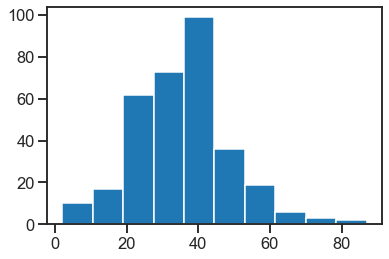

In [7]:
plt.hist(np.array(list(dict(G.degree).values())))

In [8]:
epistatic = epimodels.static(G, N)

In [9]:
epistatic.init(beta = 0.06)

In [10]:
# infected = range(200)
infected = np.random.choice(N, size = 50, replace = False)
epistatic.init_infected(infected)

In [11]:
nsims = 50
sims  = []

return_statuses = ('S', 'E', 'I', 'H', 'R', 'D')

for kk in tqdm(np.arange(nsims), desc = 'Simulations'):
    sim = epistatic.simulate(return_statuses)
    sims.append(sim)

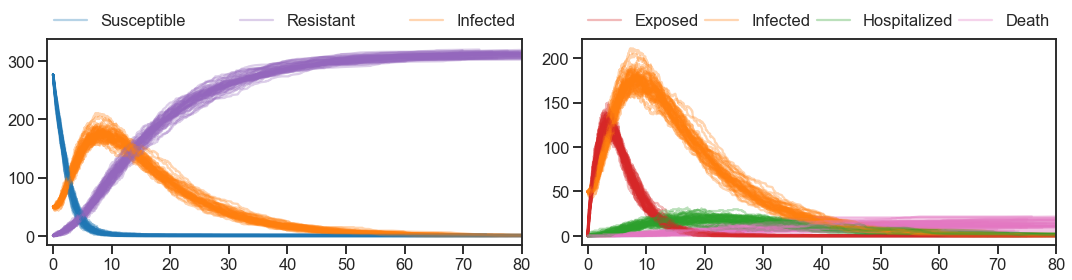

In [12]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))
alpha = .32

for sim in tqdm(sims, desc = 'Simulations'):
    times, states = sim.summary()
    axes[0].plot(times, states['S'], color = 'C0', alpha = alpha)
    axes[0].plot(times, states['R'], color = 'C4', alpha = alpha)
    axes[0].plot(times, states['I'], color = 'C1', alpha = alpha)

    axes[1].plot(times, states['E'], color = 'C3', alpha = alpha)
    axes[1].plot(times, states['I'], color = 'C1', alpha = alpha)
    axes[1].plot(times, states['H'], color = 'C2', alpha = alpha)
    axes[1].plot(times, states['D'], color = 'C6', alpha = alpha)

axes[0].legend(['Susceptible', 'Resistant', 'Infected'], 
               bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.);
axes[1].legend(['Exposed', 'Infected', 'Hospitalized', 'Death'], 
              bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=4, mode="expand", borderaxespad=0.);

for ax in axes:
    ax.set_xlim(-1, 80)

plt.tight_layout()

In [13]:
np.percentile(np.diff(sim.t()), q = [50, 90, 95, 99.999])

array([ 0.0161484 ,  0.13002263,  0.28633129, 10.9974005 ])

In [14]:
E, I, H, R, D = np.zeros([5, N])
S = np.ones(N,)
I[infected] = 1.
S[infected] = 0.

In [15]:
y0 = np.hstack((S, E, I, H, R, D))
T = 300
t = np.linspace(0,T,201)

In [16]:
start_time = time.time()

epistatic.set_solver(T = T, dt = 30.)
ke = epistatic.solve(y0, t)

elapsed_time = time.time() - start_time
tqdm.write('Runtime: ' + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Runtime: 00:00:02


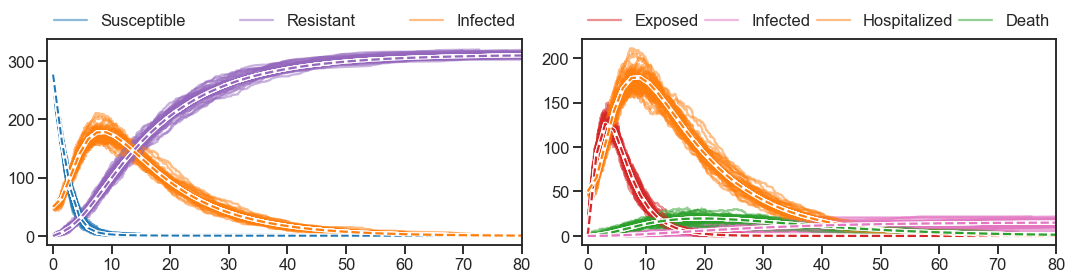

In [17]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))

alpha = .5

for sim in tqdm(sims, desc = 'Simulations'):
    times, states = sim.summary()
    axes[0].plot(times, states['S'], color = 'C0', alpha = alpha)
    axes[0].plot(times, states['R'], color = 'C4', alpha = alpha)
    axes[0].plot(times, states['I'], color = 'C1', alpha = alpha)
    
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[0], color = 'white', linestyle = '-', linewidth = 4)
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[0], color = 'C0', linestyle = '--', linewidth = 2)
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-2], color = 'white', linestyle = '-', linewidth = 4)
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-2], color = 'C4', linestyle = '--')
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[2], color = 'white', linestyle = '-', linewidth = 4)
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[2], color = 'C1', linestyle = '--')
    
    axes[1].plot(times, states['E'], color = 'C3', alpha = alpha)
    axes[1].plot(times, states['D'], color = 'C6', alpha = alpha)
    axes[1].plot(times, states['I'], color = 'C1', alpha = alpha)
    axes[1].plot(times, states['H'], color = 'C2', alpha = alpha)
    
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[1], color = 'white', linestyle = '-', linewidth = 4)
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[1], color = 'C3', linestyle = '--')
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[2], color = 'white', linestyle = '-', linewidth = 4)
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[2], color = 'C1', linestyle = '--')
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-3], color = 'white', linestyle = '-', linewidth = 4)
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-3], color = 'C2', linestyle = '--')
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-1], color = 'white', linestyle = '-', linewidth = 4)
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-1], color = 'C6', linestyle = '--')
    
axes[0].legend(['Susceptible', 'Resistant', 'Infected'], 
               bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.);
axes[1].legend(['Exposed', 'Infected', 'Hospitalized', 'Death'], 
              bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=4, mode="expand", borderaxespad=0.);
    
for ax in axes:
    ax.set_xlim(-1, 80)

plt.tight_layout()

# Heterogeneous individuals

In [18]:
sigma     = pm.InverseGamma.dist(alpha = 2, beta = 1./3)

m = 1.8
s = 0.9
invgamma  = pm.Lognormal.dist(mu = np.log(m/np.sqrt(1. + (s/m)**2)), sigma = 2*np.log(1. + (s/m)**2))
s = 1.2
invgammap = pm.Lognormal.dist(mu = np.log(m/np.sqrt(1. + (s/m)**2)), sigma = 2*np.log(1. + (s/m)**2))

h         = pm.Beta.dist(mu = 0.15, sigma = .15)
d         = pm.Beta.dist(mu = 0.14, sigma = .15)
dp        = pm.Beta.dist(mu = 0.42, sigma = .15)

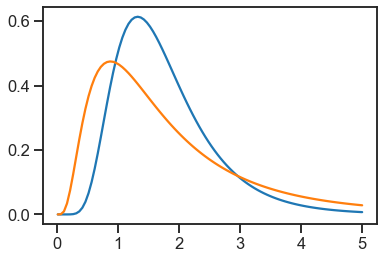

In [19]:
domain = np.linspace(0.01, 5, 100)

m = 1.8 
s = 0.9
invgamma = pm.Lognormal.dist(mu = np.log(m/np.sqrt(1. + (s/m)**2)), sigma = 2*np.log(1. + (s/m)**2))
plt.plot(domain, [np.exp(invgamma.logp(x).eval()) for x in domain], color = 'C0', label = 'Small variance')

m = 1.8 
s = 1.2
invgamma = pm.Lognormal.dist(mu = np.log(m/np.sqrt(1. + (s/m)**2)), sigma = 2*np.log(1. + (s/m)**2))
plt.plot(domain, [np.exp(invgamma.logp(x).eval()) for x in domain], color = 'C1', label = 'Large Variance')

array([0.009, 0.101, 0.262])

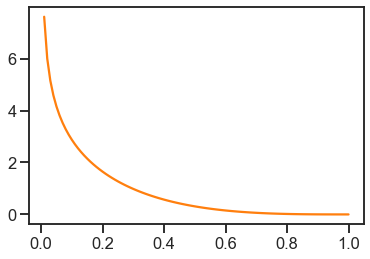

In [20]:
domain = np.linspace(0.01, 1, 100)

beta = pm.Beta.dist(mu = 0.15, sigma = .15)
plt.plot(domain, [np.exp(beta.logp(x).eval()) for x in domain], color = 'C1', label = 'Large Variance')

np.round(np.percentile(beta.random(size = 10000), q = [10, 50, 80]), 3)

In [21]:
np.random.seed(1)

sigma_samps     = sigma.random(size = N)
gamma_samps     = 1./invgamma.random(size = N)
gammap_samps    = 1./(invgammap.random(size = N) + 5.5)
h_samps         = h.random(size = N)
d_samps         = d.random(size = N)
dp_samps        = dp.random(size = N)


In [22]:
G_het = G.copy()

In [23]:
attrs_dict = defaultdict()

for kk, node in enumerate(list(G_het.nodes())):
    attrs = {'sigma': sigma_samps[kk],
            'gamma': gamma_samps[kk],
            'gammap': gammap_samps[kk],
            'theta' : (1 - h_samps[kk] - d_samps[kk]) * gamma_samps[kk],
            'delta' : h_samps[kk] * gamma_samps[kk],
            'mu'    : d_samps[kk] * gamma_samps[kk],
            'thetap': (1 - dp_samps[kk]) * gammap_samps[kk],
            'mup'   : dp_samps[kk] * gammap_samps[kk]}
    
    attrs_dict[node] = attrs

In [24]:
nx.set_node_attributes(G_het, attrs_dict)

In [25]:
varnames = ['sigma','theta','delta','mu','thetap','mup']
homnames = ['sigma','gamma','delta','mu','gammap','mup']

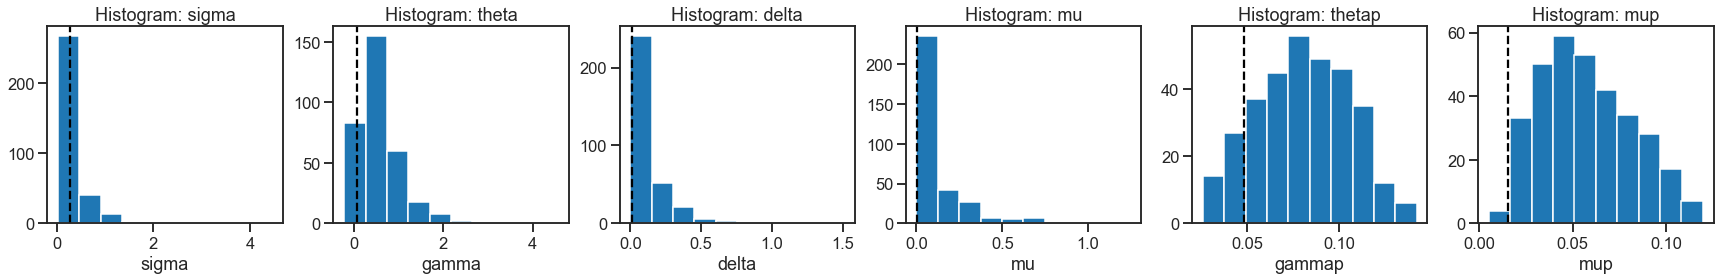

In [26]:
fig, axes = plt.subplots(1, 6, figsize = (24, 4))

for kk, ax in enumerate(axes):
    ax.hist(np.array(list(nx.get_node_attributes(G_het, varnames[kk]).values())))
    ax.axvline(getattr(epistatic, homnames[kk]), linestyle = '--', color = 'black')
    ax.set_title('Histogram: ' + varnames[kk])
    ax.set_xlabel(homnames[kk])
#     ax.set_yscale('log')
#     ax.set_xscale('log')

plt.tight_layout()

In [27]:
# # """
# # Checking to get the same behaviour as the homogeneized cased
# # """

# attrs_dict = defaultdict()

# for kk, node in enumerate(list(G_het.nodes())):
#     attrs = {'sigma': sigma_samps[kk],
#             'gamma': gamma_samps[kk],
#             'gammap': gammap_samps[kk],
#             'theta' : (1 - h_samps[kk] - d_samps[kk]) * gamma_samps[kk],
#             'delta' : h_samps[kk] * gamma_samps[kk],
#             'mu'    : d_samps[kk] * gamma_samps[kk],
#             'thetap': (1 - dp_samps[kk]) * gammap_samps[kk],
#             'mup'   : dp_samps[kk] * gammap_samps[kk]}
    
# #     attrs = {'sigma':  epistatic.sigma * np.random.uniform(.5, 1.5) ,
# #             'gamma':  (epistatic.gamma + epistatic.delta + epistatic.mu) * np.random.uniform(.5, 1.5) ,
# #             'gammap':  (epistatic.gammap + epistatic.mup) * np.random.uniform(.5, 1.5) ,
# #             'theta' :  epistatic.gamma * np.random.uniform(.5, 1.5) ,
# #             'delta' :  epistatic.delta * np.random.uniform(.5, 1.5) ,
# #             'mu'    :  epistatic.mu * np.random.uniform(.5, 1.5) ,
# #             'thetap':  epistatic.gammap * np.random.uniform(.5, 1.5) ,
# #             'mup'   :  epistatic.mup * np.random.uniform(.5, 1.5) }
    
# #     attrs = {'sigma':  epistatic.sigma,
# #             'gamma':  (epistatic.gamma + epistatic.delta + epistatic.mu),
# #             'delta' :  epistatic.delta,
# #             'gammap':  (epistatic.gammap + epistatic.mup),
# #             'theta' :  epistatic.gamma,
# #             'thetap':  epistatic.gammap,
# #             'mu'    :  epistatic.mu,
# #             'mup'   :  epistatic.mup}
    
#     attrs_dict[node] = attrs
    
# nx.set_node_attributes(G_het, attrs_dict)

In [28]:
epistatic_het = epimodels.static(G_het, N)

In [29]:
epistatic_het.init(beta = 0.06, het = True)

In [30]:
epistatic_het.init_infected(infected)

In [31]:
nsims = 50
sims_het  = []

return_statuses = ('S', 'E', 'I', 'H', 'R', 'D')

for kk in tqdm(np.arange(nsims), desc = 'Simulations'):
    sim = epistatic_het.simulate(return_statuses)
    sims_het.append(sim)

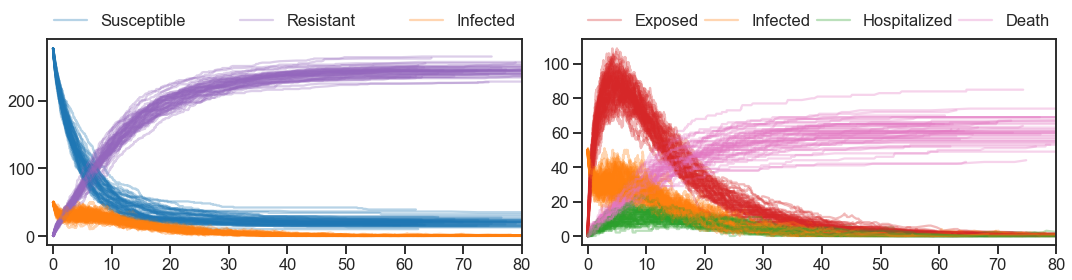

In [32]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))
alpha = .32

for sim in tqdm(sims_het, desc = 'Simulations'):
    times, states = sim.summary()
    axes[0].plot(times, states['S'], color = 'C0', alpha = alpha)
    axes[0].plot(times, states['R'], color = 'C4', alpha = alpha)
    axes[0].plot(times, states['I'], color = 'C1', alpha = alpha)

    axes[1].plot(times, states['E'], color = 'C3', alpha = alpha)
    axes[1].plot(times, states['I'], color = 'C1', alpha = alpha)
    axes[1].plot(times, states['H'], color = 'C2', alpha = alpha)
    axes[1].plot(times, states['D'], color = 'C6', alpha = alpha)

axes[0].legend(['Susceptible', 'Resistant', 'Infected'], 
               bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.);
axes[1].legend(['Exposed', 'Infected', 'Hospitalized', 'Death'], 
              bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=4, mode="expand", borderaxespad=0.);

for ax in axes:
    ax.set_xlim(-1, 80)
    
plt.tight_layout()

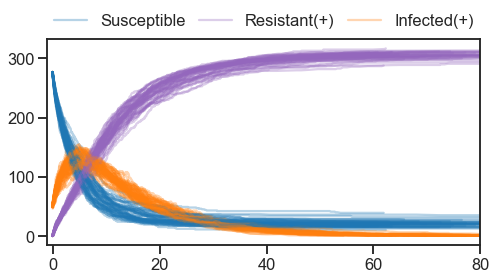

In [33]:
fig, axes = plt.subplots(1, 1, figsize = (7, 4))
alpha = .32

for sim in tqdm(sims_het, desc = 'Simulations'):
    times, states = sim.summary()
    axes.plot(times, states['S'], color = 'C0', alpha = alpha)
    axes.plot(times, states['R'] + states['D'], color = 'C4', alpha = alpha)
    axes.plot(times, states['I'] + states['E'] + states['H'], color = 'C1', alpha = alpha)

axes.legend(['Susceptible', 'Resistant(+)', 'Infected(+)'], 
               bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.);

axes.set_xlim(-1, 80)
    
plt.tight_layout()

In [34]:
E, I, H, R, D = np.zeros([5, N])
S = np.ones(N,)
I[infected] = 1.
S[infected] = 0.

In [35]:
y0 = np.hstack((S, E, I, H, R, D))
T = 300
t = np.linspace(0,T,201)

In [36]:
start_time = time.time()

epistatic_het.set_solver(T = T, dt = 15.)
ke = epistatic_het.solve(y0, t)

elapsed_time = time.time() - start_time
tqdm.write('Runtime: ' + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Runtime: 00:00:25


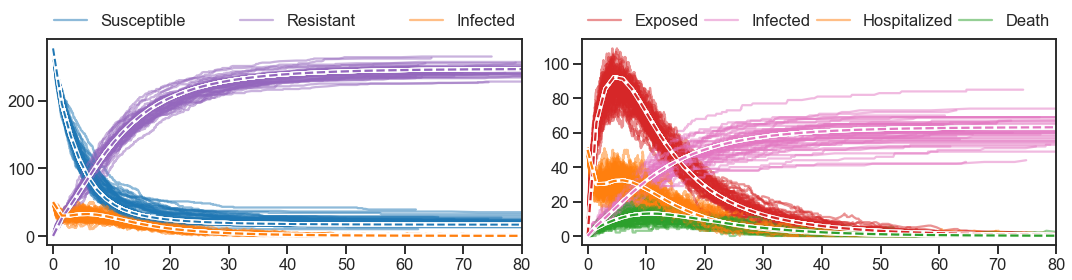

In [37]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))

alpha = .5

for sim in tqdm(sims_het, desc = 'Simulations'):
    times, states = sim.summary()
    axes[0].plot(times, states['S'], color = 'C0', alpha = alpha)
    axes[0].plot(times, states['R'], color = 'C4', alpha = alpha)
    axes[0].plot(times, states['I'], color = 'C1', alpha = alpha)
    
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[0], color = 'white', linestyle = '-', linewidth = 4)
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[0], color = 'C0', linestyle = '--', linewidth = 2)
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-2], color = 'white', linestyle = '-', linewidth = 4)
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-2], color = 'C4', linestyle = '--')
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[2], color = 'white', linestyle = '-', linewidth = 4)
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[2], color = 'C1', linestyle = '--')
    
    axes[1].plot(times, states['E'], color = 'C3', alpha = alpha)
    axes[1].plot(times, states['D'], color = 'C6', alpha = alpha)
    axes[1].plot(times, states['I'], color = 'C1', alpha = alpha)
    axes[1].plot(times, states['H'], color = 'C2', alpha = alpha)
    
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[1], color = 'white', linestyle = '-', linewidth = 4)
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[1], color = 'C3', linestyle = '--')
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[2], color = 'white', linestyle = '-', linewidth = 4)
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[2], color = 'C1', linestyle = '--')
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-3], color = 'white', linestyle = '-', linewidth = 4)
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-3], color = 'C2', linestyle = '--')
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-1], color = 'white', linestyle = '-', linewidth = 4)
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-1], color = 'C6', linestyle = '--')
    
axes[0].legend(['Susceptible', 'Resistant', 'Infected'], 
               bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.);
axes[1].legend(['Exposed', 'Infected', 'Hospitalized', 'Death'], 
              bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=4, mode="expand", borderaxespad=0.);
    
for ax in axes:
    ax.set_xlim(-1, 80)
    
plt.tight_layout()